# Import the raw data 
Source: https://www.eia.gov/electricity/wholesale/

In [1]:
# Library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

First let's analyze the 2024 data. I use Pandas to load and visualize the data. 

I convert all date columns into Pandas datetime. 

In [ ]:
# Load the 2024 data
folder_path = "../data/raw/"
file_name = "ice_electric-2024final.xlsx"

# Create dataframe
df = pd.read_excel(folder_path + file_name)

# Rename the columns to be more code-friendly
df.columns = [
    "price_hub", "trade_date", "delivery_start_date", "delivery_end_date",
    "high_price", "low_price", "avg_price", "price_change",
    "daily_volume", "num_trades", "num_counterparties"
]

# Remove non-numerical column price_hub (can be useful, but we keep this exercise simple)
numeric_cols = df.select_dtypes(include='number').columns
trade_date = df["trade_date"]
numeric = df[numeric_cols]
df = pd.concat([trade_date, numeric], axis=1)

# Convert dates to datetime
df["trade_date"] = pd.to_datetime(df["trade_date"])
# Set trade date as index
df.set_index("trade_date", inplace=True)

# Sort by date (nice when plotting)
df.sort_index(inplace=True)

df.head(n=5)

,high_price,low_price,avg_price,price_change,daily_volume,num_trades,num_counterparties
trade_date,,,,,,,
2023-12-27,37.50,34.00,35.27,-0.93,9600,12,11
2023-12-27,38.50,37.50,38.00,3.00,1600,2,3
2023-12-27,30.25,30.00,30.06,-23.94,3200,4,6
2023-12-27,36.00,34.00,35.54,6.45,4800,6,4
2023-12-27,28.10,27.85,27.93,0.88,2400,3,5


### Data processing
We will now check for Infs, NaNs and handle the cases where there are multiple data points per day (happens as we have multiple price hubs).

We will not be using the price_hub for this exercise, and because they are categorical (i.e. not numerical), I will be removing them for ease of use.

In [3]:
# Aggregate
df = df.groupby(df.index).mean()

# Add frequency
df = df.asfreq("D")

# Check for Infs
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_df = df.select_dtypes(include=numerics)
print("Columns with Infs:")
print(numeric_df.columns.to_series()[np.isinf(numeric_df).any()])

# Replace NaNs using forward fill (i.e. replace NaNs with the previous valid value)
print("\nNumber of missing values:\n", df.isnull().sum())
df = df.ffill();

df.head(n=5)

Columns with Infs:
Series([], dtype: object)

Number of missing values:
 high_price            132
low_price             132
avg_price             132
price_change          132
daily_volume          132
num_trades            132
num_counterparties    132
dtype: int64


,high_price,low_price,avg_price,price_change,daily_volume,num_trades,num_counterparties
trade_date,,,,,,,
2023-12-27,34.07,32.67,33.360,-2.908,4320.0,5.4,5.8
2023-12-28,32.40,30.19,30.866,-2.494,6560.0,12.6,8.4
2023-12-29,46.40,40.20,42.536,12.032,7200.0,14.2,12.0
2023-12-30,46.40,40.20,42.536,12.032,7200.0,14.2,12.0
2023-12-31,46.40,40.20,42.536,12.032,7200.0,14.2,12.0


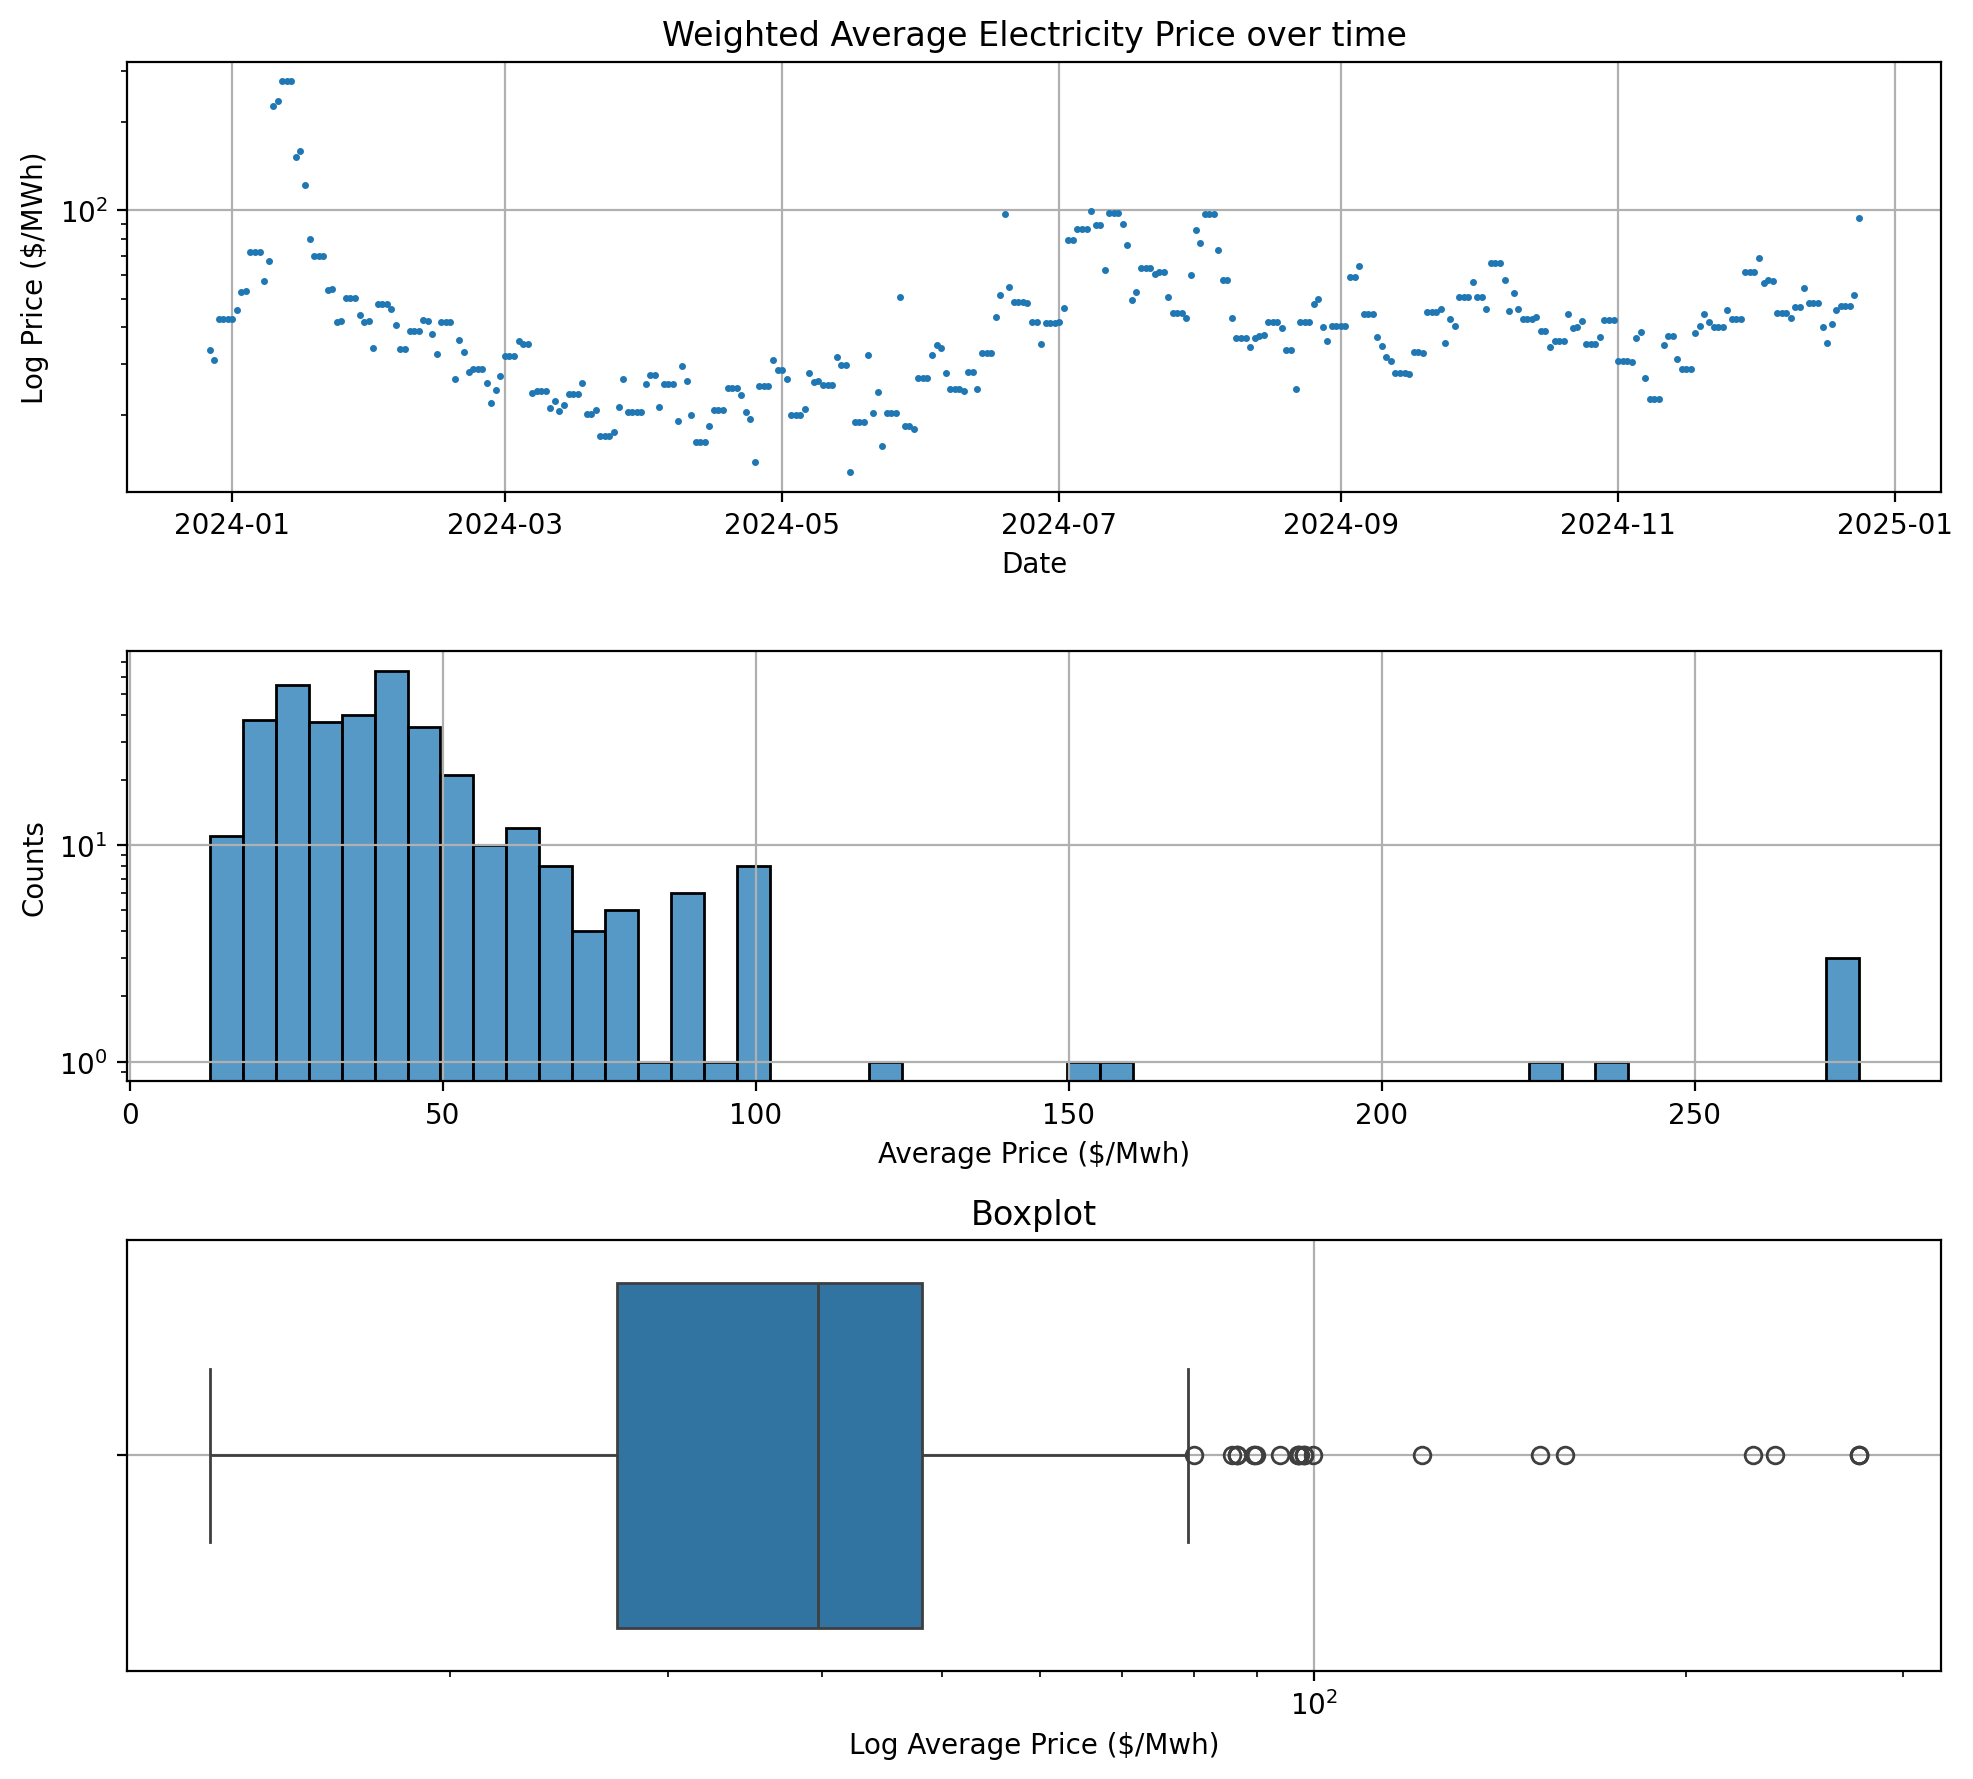

In [4]:
# Visualize data
fig, axs = plt.subplots(figsize=(10, 9), nrows=3, ncols=1, dpi=200)
ax, ax_dist, ax_boxplot = axs

# Time series
ax.plot(df["avg_price"], ".", markersize=3)
ax.set(xlabel="Date", ylabel="Log Price ($/MWh)", title="Weighted Average Electricity Price over time", yscale="log")
ax.grid()

# Price distribution
bin_range = (np.min(df["avg_price"]), np.max(df["avg_price"]))
sns.histplot(df["avg_price"], 
             bins=50, 
             ax=ax_dist,
             log_scale=False, 
             binrange=bin_range)
ax_dist.set(xlabel="Average Price ($/Mwh)", ylabel="Counts", yscale="log")
ax_dist.grid()

# Boxplot for potential anomalies
sns.boxplot(x=df["avg_price"], ax=ax_boxplot)
ax_boxplot.grid()
ax_boxplot.set(xlabel="Log Average Price ($/Mwh)", title="Boxplot")
ax_boxplot.set(xscale="log")

fig.tight_layout()
plt.show()

#### Interpretation of graphs
From all three plots, it becomes obvious that we are dealing with outliers. 

The time series plot (the top panel) shows that the values most of the time have a rather low spread, except the short peark in January (1st month), and between March (3rd month) and Juli (7th month) we see a lot more low prices. 

At a first glance, it seems the data shows a trend in the latter half of the year.


## ARIMA
We want to do some statistical forecasting using the ARIMA model. This requires us to:
1. Check stationarity with an ADF test
2. Seasonally decomposition
3. Fit to the ARIMA model

First we check for stationarity using the **ADF test**. 
Our null hypothesis H0 is that the data is non-stationary i.e. there exists (seasonal) trends. If the $p-value$ of the test is low, we reject the hypothesis in favour of stationarity.

In [5]:
# Stationarity (meaning no seasonal or similar trends)
ADF_results = adfuller(df["avg_price"])
ADF_test_t, ADF_p_value = ADF_results[0], ADF_results[1]
print("AD test statistic: ", ADF_test_t)
print("p-value: ", ADF_p_value)

# We use the criteria of p < 0.05 to reject our null hypothesis of non-stationarity.
reject_H0_criteria = ADF_p_value < 0.05
if reject_H0_criteria:
    print("The average price is likely stationary (we rejected H0)")
else:
    print("The average price is likely non-stationary (we failed to reject H0)")

AD test statistic:  -3.831522860192699
p-value:  0.0026007700859124725
The average price is likely stationary (we rejected H0)


A brief reminder on $p$-values: The $p-value tells you how likely it is to get the measurements you have under your initial assumption (null hypothesis H0). In our context, we have initially assume that the average electricity price is non-stationary. However, we get a $p$-value of roughly $0.1\%$, meaning it is quite unlikely to see the electricity prices that we have if we assume prices are indeed non-stationary. Thus, we conclude that the data is **most likely** (as we can never be deterministically certain) is stationary.

Based on the plots, we did initially say that it looked as if some trends exist, but it might just be noise.

Next, even though the believe our data is stationary, it can be helpful to perform **seasonal decomposition**.

The idea behind seasonal decomposition is to see the data as consisting of different terms: a trend $T_t$, a seasonality $S_t$ and the remainder/residual $R_t$, such that the data $y_t$ is:
$$ y_t = T_t + S_t + R_t $$
Where $t$ is a chosen periodicity (we choose $t=7$ below as our data is in days and a week seems like a probable period to investigate).

Alternatively, a multiplicative decomposition can be used:
$$ y_t = T_t \, S_t  \, R_t $$
But we will use the additive as we have negative values, for which the multiplicative decomposition is inappropriate

In [6]:
def plot_decomposition(period):
    decomposition = seasonal_decompose(df["avg_price"], model="additive", period=period)

    # Plot the decomposition
    fig, (ax_obs, ax_trend, ax_seasonal, ax_resid) = plt.subplots(figsize=(12, 10), ncols=1, nrows=4)

    # Observed data (i.e. just the average price over time)
    ax_obs.plot(decomposition.observed, marker=".", ls="", markersize=3)
    ax_obs.set(ylabel="Data ($/Mwh)")
    ax_obs.grid()

    # Trend
    ax_trend.plot(decomposition.trend, marker=".", ls="", markersize=3)
    ax_trend.set(ylabel=r"Trend $T$ ($/Mwh)")
    ax_trend.grid()

    # Seasonality
    ax_seasonal.plot(decomposition.seasonal, marker=".", ls="-", markersize=3)
    ax_seasonal.grid()
    ax_seasonal.set(ylabel=r"Seasonality $S$ ($/Mwh)")

    # Residual/Remainder
    ax_resid.plot(decomposition.resid, marker=".", ls="", markersize=3)
    ax_resid.set(ylabel=r"Residual $R$ ($/Mwh)",)
    ax_resid.grid()

    fig.suptitle(f"Seasonal decomposition of electricity prices, period = {period}")
    fig.tight_layout()
    plt.show()

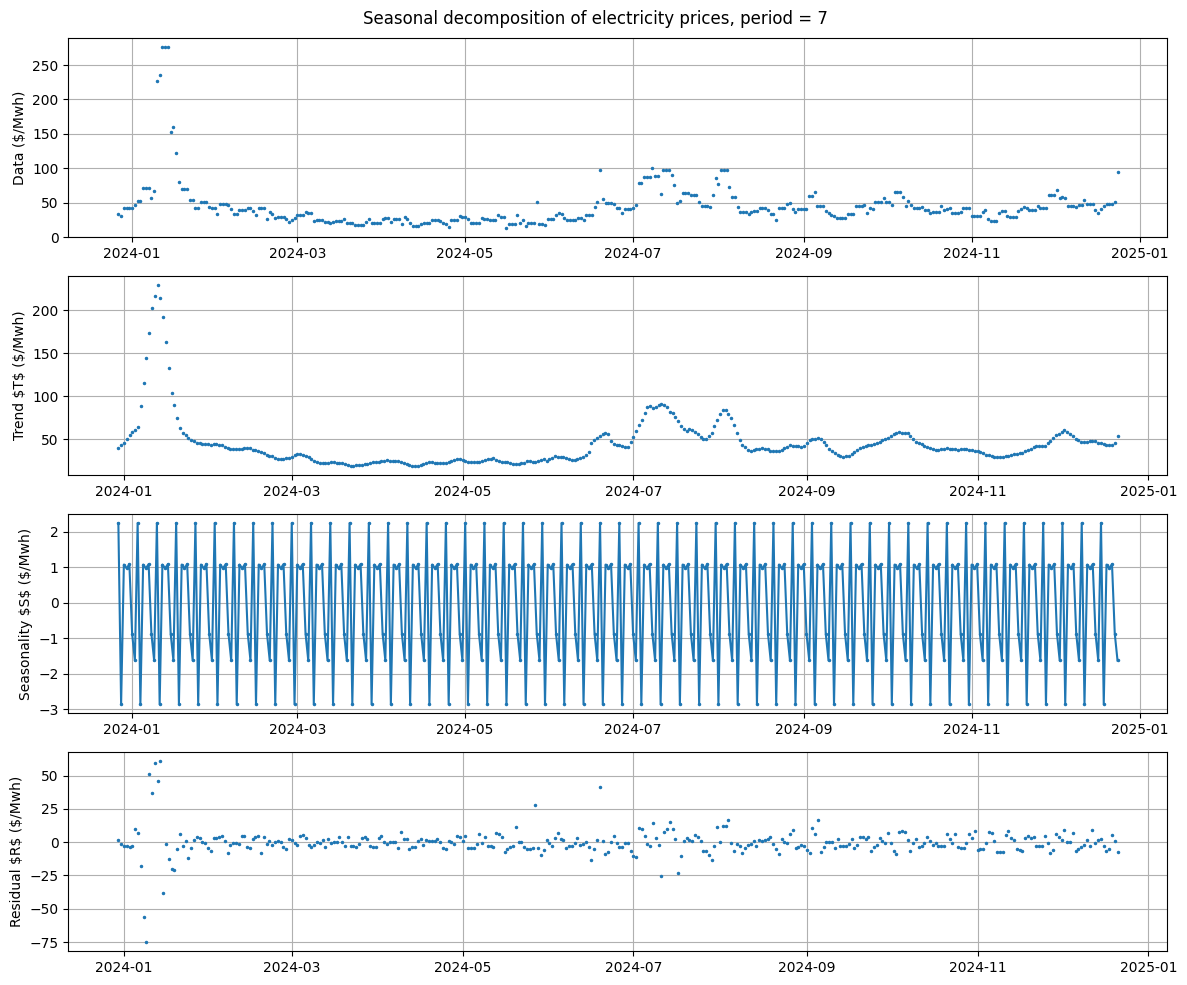

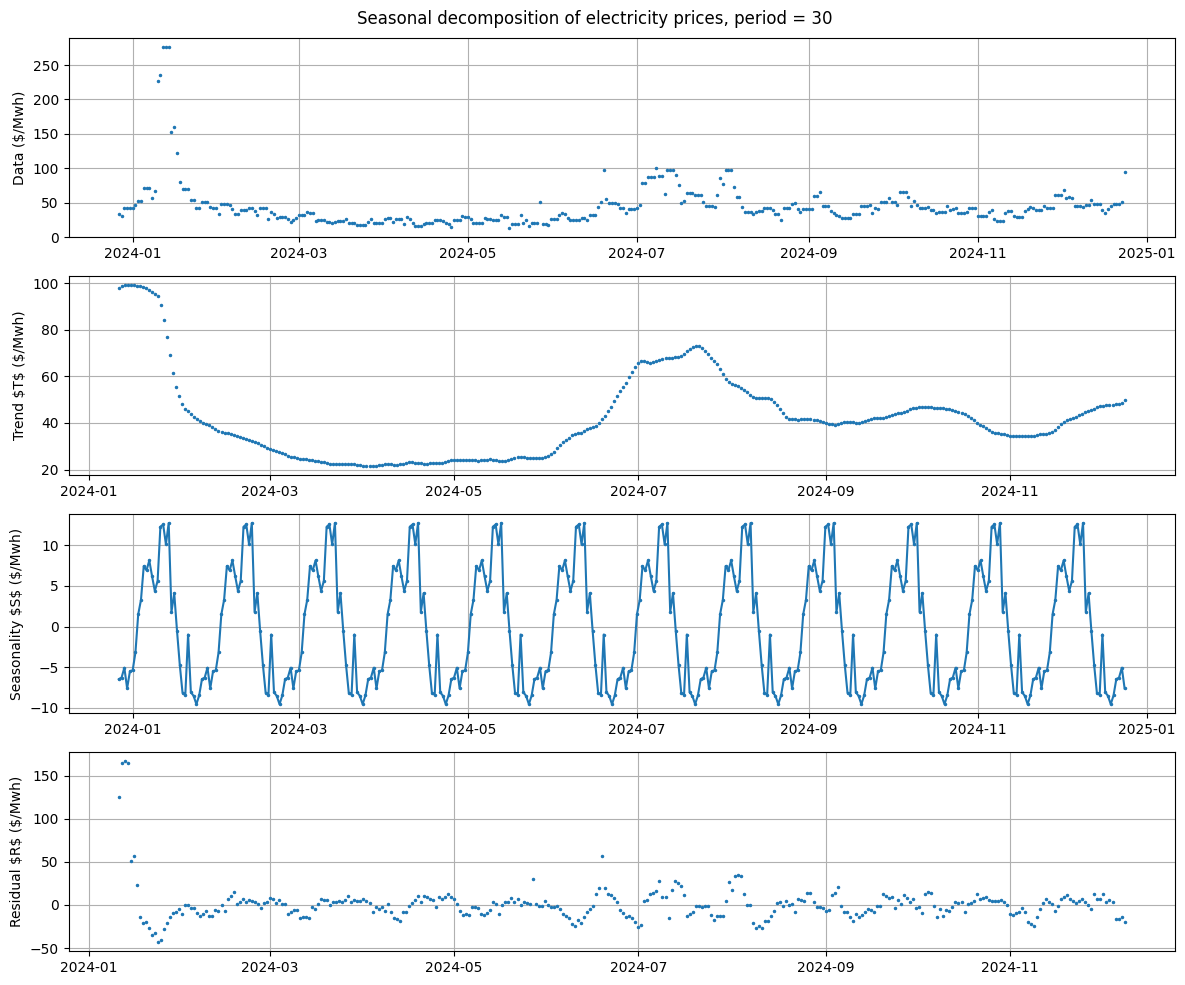

In [7]:
plot_decomposition(period=7)  # Weekly
plot_decomposition(period=30)  # Monthly

Because we have multiple data points per day (from the different electricity hubs), the seasonality graphs are hard to interpret.

Finally, **ARIMA**

In [8]:
# Perform the fit
model = sm.tsa.arima.ARIMA(df["avg_price"], order=(5, 1, 0))
arima_results = model.fit()

print(arima_results.summary())

                               SARIMAX Results                                
Dep. Variable:              avg_price   No. Observations:                  364
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -1455.089
Date:                Sun, 30 Mar 2025   AIC                           2922.178
Time:                        13:49:15   BIC                           2945.544
Sample:                    12-27-2023   HQIC                          2931.466
                         - 12-24-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0051      0.054      0.095      0.924      -0.101       0.111
ar.L2          0.1465      0.053      2.775      0.006       0.043       0.250
ar.L3          0.0095      0.036      0.262      0.7

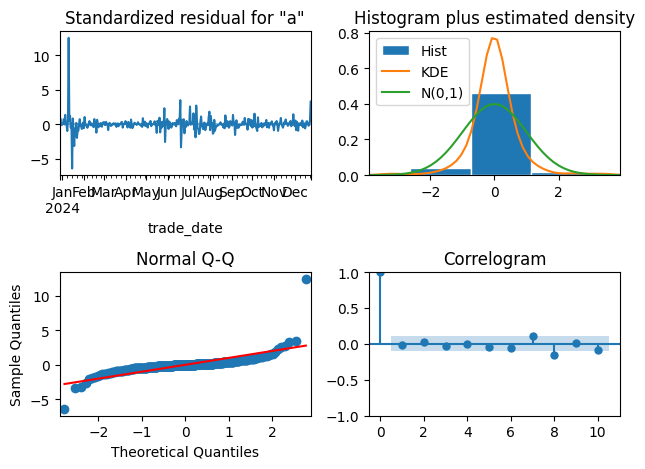

In [9]:
# Plot Diagnostics
fig = arima_results.plot_diagnostics()
fig.tight_layout()
plt.show()

On the Normal Q-Q plot, data values are normal distributed if they lie near the red line. We see this is mostly true except at the ends. It is also worthwile to stress how the values clearly are not randomly distributed along the red line, but shows a clear pattern.

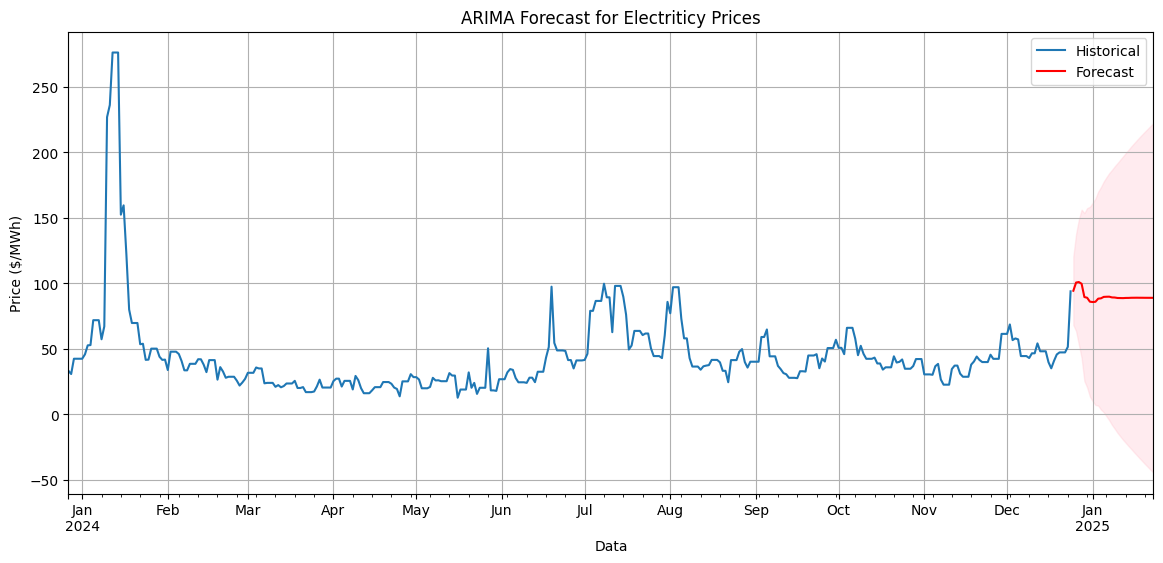

In [13]:
# Plot forecasts
arima_forecast = arima_results.get_forecast(steps=30)
arima_forecast_ci = arima_forecast.conf_int()  # Confidence interval

fig, ax_forecast = plt.subplots(figsize=(14, 6))
df["avg_price"].plot(label="Historical")
arima_forecast.predicted_mean.plot(label="Forecast", color="r")
ax_forecast.fill_between(arima_forecast_ci.index, 
                         arima_forecast_ci.iloc[:, 0],
                        arima_forecast_ci.iloc[:, 1],
                        color="pink", alpha=0.3)
ax_forecast.set(xlabel="Data", ylabel="Price ($/MWh)", title="ARIMA Forecast for Electriticy Prices")
ax_forecast.grid()
ax_forecast.legend()
plt.show()

Now, our forecast is obsviously not all that great.

... But we can expect more data to fix this. We only looked at a single year, and at a single variable (average price)